<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#import necessary libraries
import pandas as pd
import numpy as np

In [19]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Data Science/cleaned_traincsv (3).csv")

In [20]:
# Drop Customer_ID (not useful for prediction)
df_cleaned = df.drop(columns=['Customer_ID'])

In [21]:
# Define features and target
X = df_cleaned.drop(columns=['cluster_catgeory'])  # Features
y = df_cleaned['cluster_catgeory']  # Target variable

In [22]:
#check that the list of input variables
list(X)

['outlet_city', 'luxury_sales', 'fresh_sales', 'dry_sales']

In [23]:
#check that the list of target variable
y.head()

,cluster_catgeory
0,4.0
1,1.0
2,4.0
3,4.0
4,4.0


In [24]:
# Before creating LightGBM datasets, ensure labels are in the correct range
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_encoded = label_encoder.fit_transform(y)

# Now use the encoded target variable for splitting and creating LightGBM datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=14, stratify=y_encoded)


#This is to show the number of instances and input features in the training and test sets
print('X_train Instances', X_train.shape)
print('X_test Instances', X_test.shape)


X_train Instances (619226, 4)
X_test Instances (154807, 4)


In [25]:
from imblearn.over_sampling import SMOTE
# For handling imbalanced data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [26]:
# Create LightGBM dataset format
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [27]:
import lightgbm as lgb

# Optimized parameters
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y)),
    "metric": "multi_logloss",
    "boosting_type": "dart",
    "learning_rate": 0.03,
    "class_weight" : "balanced",
    "num_leaves": 10,
    "max_depth": 3,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_freq": 3,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "num_threads": 4,
    "device": "cpu",
    "early_stopping_rounds": 50
}

In [28]:
num_boost_round = 150  # Number of trees

# Train LightGBM with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=num_boost_round,
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 906990, number of used features: 4
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [29]:
 #Make predictions
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(line) for line in y_pred]  # Convert probability output to class

In [30]:
# Evaluate model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_classes))

Accuracy: 0.9136
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     37791
           1       0.87      0.97      0.91     31007
           2       0.86      0.71      0.78      9778
           3       0.90      0.99      0.95     34485
           4       0.71      0.86      0.78      7905
           5       0.97      0.86      0.91     33841

    accuracy                           0.91    154807
   macro avg       0.88      0.88      0.88    154807
weighted avg       0.92      0.91      0.91    154807



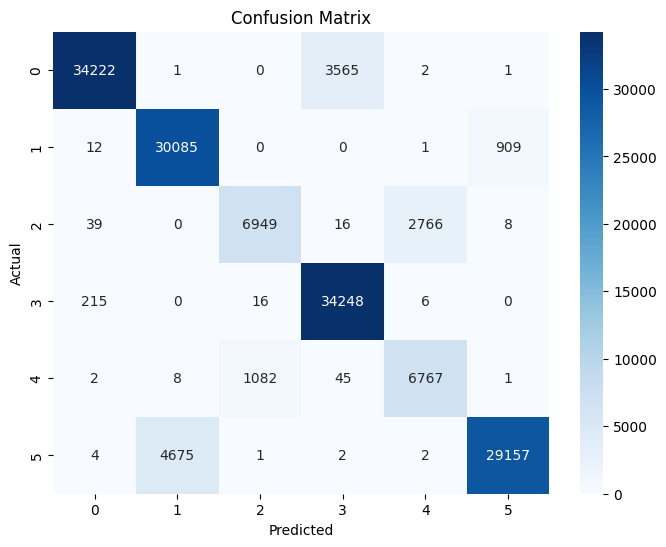

In [31]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

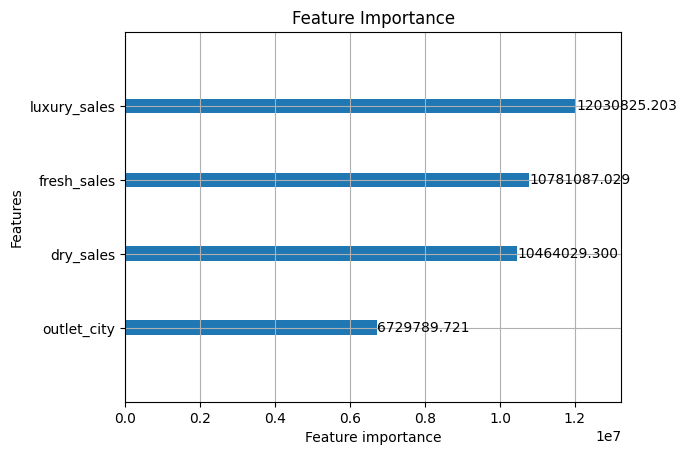

In [32]:
# Feature importance visualization
lgb.plot_importance(model, max_num_features=10, importance_type="gain")
plt.title("Feature Importance")
plt.show()

In [33]:
!pip install --upgrade lightgbm

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 906990, number of used features: 4
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

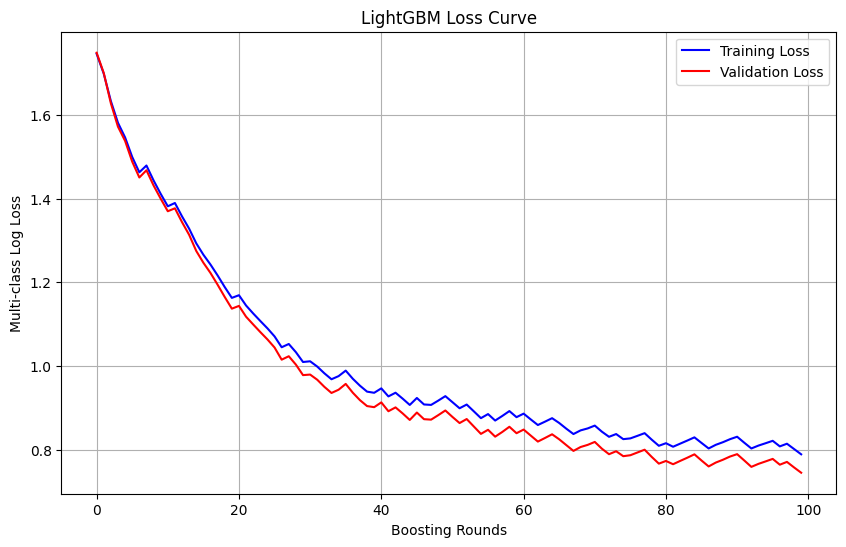

In [34]:
import lightgbm as lgb

# Dictionary to store training history
evals_result = {}

import warnings
warnings.filterwarnings("ignore")

# Train LightGBM model and log loss values
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],  # Monitor both training & validation loss
    valid_names=["Train", "Validation"],
    num_boost_round=100,
    # 'early_stopping_rounds' is moved to the callbacks list
    callbacks=[lgb.early_stopping(20, verbose=True), lgb.record_evaluation(evals_result)],
)

# Extract loss values
train_loss = evals_result["Train"]["multi_logloss"]
val_loss = evals_result["Validation"]["multi_logloss"]
epochs = range(len(train_loss))

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Rounds")
plt.ylabel("Multi-class Log Loss")
plt.title("LightGBM Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 906990, number of used features: 4
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

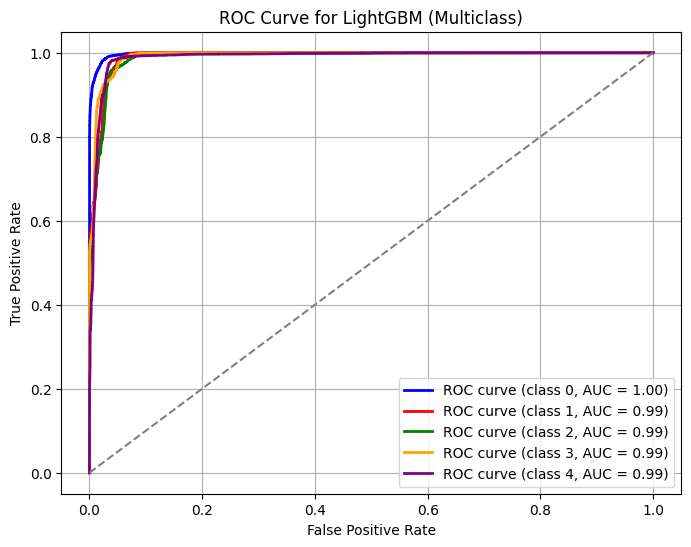

In [39]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Train LightGBM model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    # Pass early stopping as a callback
    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True)]
)

# Binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for all classes
y_pred_prob = model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LightGBM (Multiclass)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

 Test LightGBM Model on Real World Data

In [48]:
# Load test dataset
test_df = pd.read_csv("/content/drive/MyDrive/Data Science/cleaned_test.csv")

In [49]:
# Display first few rows
print(test_df.head())

   Customer_ID outlet_city  luxury_sales  fresh_sales  dry_sales
0        33574  Batticaloa       2686.50      3582.00   12537.00
1        10089  Batticaloa       1717.56      2576.34    9446.58
2        38329  Batticaloa        854.04      1242.24    5201.88
3        11376  Batticaloa       1638.12      2320.67    9282.68
4        12410  Batticaloa       1039.09      1518.67    5435.24


In [50]:
# Remove unnecessary columns for testing
if "CustomerID" in test_df.columns:
    test_df = test_df.drop(columns=["CustomerID"])

In [51]:
# Ensure test dataset contains only the features used for training
X_real_test = test_df[['outlet_city', 'luxury_sales', 'fresh_sales', 'dry_sales']]  # Use same features from training data

# Display the shape to confirm
print(f"Test dataset shape: {X_real_test.shape}")

Test dataset shape: (40749, 4)


In [53]:
# Ensure 'outlet_city' is a string type
if 'outlet_city' in test_df.columns:
    test_df['outlet_city'] = test_df['outlet_city'].astype(str)

In [56]:
# Apply the same encoding as in training
if 'outlet_city' in df.columns:  # Ensure training data had 'outlet_city'
    outlet_city_encoder = LabelEncoder()
    outlet_city_encoder.fit(df['outlet_city'])  # Fit on training data
    # Transform the 'outlet_city' column in the test data
    test_df['outlet_city'] = outlet_city_encoder.transform(test_df['outlet_city']) # Apply transform to test data


ValueError: invalid literal for int() with base 10: 'Batticaloa'

In [55]:
# Make predictions using trained LightGBM model
y_pred_real = model.predict(X_real_test)

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: outlet_city: object